# Part 1
NLP(자연어처리)는 텍스트 문제에 접근하기 위한 기술집합이다. 

이 튜토리얼에서는 IMDB 영화 리뷰를 로딩하고 정제하여 간단한 BOW(Bag Of Words)모델을 적용해서 리뷰가 추천인지 아닌지에 대한 정확도를 예측한다.

In [1]:
import pandas as pd

"""
header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며
delimiter = \t 는 필드가 탭으로 구분되는 것을 의미한다.
quoting = 3은 쌍따옴표를 무시하도록 한다.
"""
# QUOTE_MINIMAL (0), QUOTE_ALL (1),
# QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

# 레이블인 sentiment 가 있는 학습 데이터
train = pd.read_csv('data/labeledTrainData.tsv',
                   header=0, delimiter='\t', quoting=3)
# 레이블이 없는 데스트 데이터
test = pd.read_csv('data/TestData.tsv',
                   header=0, delimiter='\t', quoting=3)

In [2]:
train.shape

(25000, 3)

In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
test.shape

(25000, 2)

In [5]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [6]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [7]:
# 레이블인 'sentiment'가 없다. 이 데이터를 머신러닝을 통해 예측한다.
test.columns.values

array(['id', 'review'], dtype=object)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [9]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [10]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [11]:
# html 태그가 섞여있기 때문에 이를 정제해줄 필요가 있음
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

### 데이터 정제 Data Cleaning and Text Preprocessing
기계가 텍스트를 이해할 수 있도록 텍스트를 정제해 준다.

신호와 소음을 구분한다. 아웃라이어데이터로 인한 오버피팅을 방지한다.

    1. BeautifulSoup을 통해 HTML 태그를 제거
    2. 정규표현식으로 알파벳 이외의 문자를 공백으로 치환
    3. NLTK 데이터를 사용해 Stopword를 제거
    4. 어간추출(Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 SnowballStemmer를 통해 어간을 추출
    

### 텍스트 데이터 전처리 이해하기
(출처: https://github.com/twitter/twitter-korean-text/)

**정규화 normalization (입니닼ㅋㅋ -> 입니다 ㅋㅋ, 샤릉해 -> 사랑해)**

- 한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ -> 한국어를 처리하는 예시입니다 ㅋㅋ

**토큰화 tokenization**

- 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하는Verb, 예시Noun, 입Adjective, 니다Eomi ㅋㅋKoreanParticle

**어근화 stemming (입니다 -> 이다)**

- 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하다Verb, 예시Noun, 이다Adjective, ㅋㅋKoreanParticle

**어구 추출 phrase extraction**

- 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어, 처리, 예시, 처리하는 예시


#### 1. BeautifulSoup을 통해 HTML 태그를 제거

###### BeautifulSoup이 설치되지 않았다면 우선 설치
    !pip install bs4

In [12]:
# 설치 및 버전확인
!pip3 show BeautifulSoup4

Name: beautifulsoup4
Version: 4.6.0
Summary: Screen-scraping library
Home-page: http://www.crummy.com/software/BeautifulSoup/bs4/
Author: Leonard Richardson
Author-email: leonardr@segfault.org
License: MIT
Location: /Users/macbook/anaconda3/lib/python3.6/site-packages
Requires: 
Required-by: bs4


In [13]:
# review의 첫 번째 데이터의 HTML 태그 제거 
from bs4 import BeautifulSoup

example1 = BeautifulSoup(train['review'][0], "html5lib")
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

#### 2. 정규표현식으로 알파벳 이외의 문자를 공백으로 치환

In [14]:
# 정규표현식을 사용해서 특수문자를 제거
import re
# 소문자와 대문자가 아닌 것은 공백으로 대체한다.
# ^ : not을 의미
letters_only = re.sub('[^a-zA-z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [15]:
# 모두 소문자로 변환한다.
lower_case = letters_only.lower()
# 문자를 나눈다. => 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

####  3. NLTK 데이터를 사용해 Stopword를 제거

### 불용어 제거(Stopword Removal)

일반적으로 코퍼스에서 자주 나타나는 단어는 학습 모델로서 학습이나 예측 프로세스에 실제로 기여하지 않아 다른 텍스트와 구별하지 못한다. 예를들어 조사, 접미사, i, me, my, it, this, that, is, are 등 과 같은 단어는 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는다. Stopwords는 "to" 또는 "the"와 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK에는 153 개의 불용어가 미리 정의되어 있다. 17개의 언어에 대해 정의되어 있으며 한국어는 없다.

###### NLTK data 설치
http://corazzon.github.io/nltk_data_install

In [16]:
import nltk
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [17]:
# stopwords 를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

#### 4. SnowballStemmer를 통해 어간을 추출

### Stemming 어간추출, 형태소 분석

출처 : [어간 추출 - 위키백과](https://ko.wikipedia.org/wiki/%EC%96%B4%EA%B0%84_%EC%B6%94%EC%B6%9C)
- 어간 추출(語幹 抽出, 영어: stemming)은 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
- "message", "messages", "messaging" 과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.
- stemming(형태소 분석): 여기에서는 NLTK에서 제공하는 형태소 분석기를 사용한다. 포터 형태소 분석기는 보수적이고 랭커스터 형태소 분석기는 좀 더 적극적이다. 형태소 분석 규칙의 적극성 때문에 랭커스터 형태소 분석기는 더 많은 동음이의어 형태소를 생산한다. [참고 : 모두의 데이터 과학 with 파이썬(길벗)](http://www.gilbut.co.kr/book/bookView.aspx?bookcode=BN001787)

In [18]:
# 포터 스태머의 사용 예
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [19]:
# 랭커스터 스태머의 사용 예
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(lancaster_stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(lancaster_stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(lancaster_stemmer.stem("run")))

maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [20]:
# 처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [21]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]

# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

### Lemmatization 음소표기법

언어학에서 음소 표기법 (또는 lemmatization)은 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절된 형태의 단어를 그룹화하는 과정이다. 예를 들어, 동음이의어가 문맥에 따라 다른 의미를 갖는데 

   1) *배*가 맛있다.
   
   2) *배*를 타는 것이 재미있다.
   
   3) 평소보다 두 *배*로 많이 먹어서 *배*가 아프다.
    
위에 있는 3개의 문장에 있는 "배"는 모두 다른 의미를 갖는다.

레미타이제이션은 이때 앞뒤 문맥을 보고 단어의 의미를 식별하는 것이다. 영어에서 meet은 meeting으로 쓰였을 때 회의를 뜻하지만 meet 일 때는 만나다는 뜻을 갖는데 그 단어가 명사로 쓰였는지 동사로 쓰였는지에 따라 적합한 의미를 갖도록 추출하는 것이다. 

- 참고 :
    - [Stemming and lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)
    - [Lemmatisation - Wikipedia](https://en.wikipedia.org/wiki/Lemmatisation)

In [22]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

words = [wordnet_lemmatizer.lemmatize(w) for w in words]

# 처리 후 단어
words[:10]

fly
fly


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

하지만 이 튜토리얼에서는 Stemming과 Lemmatizing을 소개만 해서 stemming 코드를 별도로 추가하였다.

## 문자열 처리
- 위에서 간략하게 살펴본 내용을 바탕으로 함수를 만들어 문자열을 처리해 본다.

In [23]:
def review_to_words(raw_review):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. Stopwords를 세트로 변환
    # 파이썬에서는 리스트보다 세트로 찾는게 훨씬 빠르다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return(' '.join(stemming_words))

In [24]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [25]:
# 첫 번째 리뷰를 대상으로 전처리 해줬던 내용을 전체 텍스트 데이터를 대상으로 처리한다.
# 전체 리뷰 데이터 수 가져오기
num_reviews = train['review'].size
num_reviews

25000

In [26]:
"""
clean_train_reviews = []
캐글 튜토리얼에는 range가 xrange로 되어있지만
여기에서는 python3를 사용하기 때문에 range를 사용했다.
"""
# for i in range(0, num_reviews):
#     clean_train_reviews.append(review_to_words(train['review'][i]))
"""
위 코드는 어느 정도 실행이 되고 있는지 알 수가 없어서
5000개 단위로 상태를 찍도록 개선했다.
"""
clean_train_reviews = []
# for i in range(0, num_reviews):
#     if (i + 1) % 5000 == 0 :
#         print('Review {} of {}'.format(i+1, num_reviews))
#     clean_train_reviews.append(review_to_words(train['review'][i]))
"""
코드를 좀 더 간결하게 하기 위해서 
for loop를 사용하는 대신 apply를 사용하도록 개선
"""
%time train['review_clean'] = train['review'].apply(review_to_words)
"""
코드는 한 줄로 간결해 졌지만 여전히 오래 걸림
"""


CPU times: user 1min 19s, sys: 1.38 s, total: 1min 20s
Wall time: 1min 21s


'\n코드는 한 줄로 간결해 졌지만 여전히 오래 걸림\n'

In [27]:
train.head()

,id,sentiment,review,review_clean
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",stuff go moment mj start listen music watch od...
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",classic war world timothi hine entertain film ...
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",film start manag nichola bell give welcom inve...
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",must assum prais film greatest film opera ever...
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",superbl trashi wondrous unpretenti exploit hoo...


In [28]:
# 참고 : https://gist.github.com/yong27/7869662
# http://www.racketracer.com/2016/07/06/pandas-in-parallel/
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라미터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [29]:
%time clean_train_reviews = apply_by_multiprocessing(\
        train['review'], review_to_words, workers=4)

CPU times: user 110 ms, sys: 165 ms, total: 275 ms
Wall time: 44.2 s


In [30]:
%time clean_test_reviews = apply_by_multiprocessing(\
        test['review'], review_to_words, workers=4)

CPU times: user 116 ms, sys: 194 ms, total: 310 ms
Wall time: 42.3 s


### 워드 클라우드
- 단어의 빈도 수 데이터를 가지고 있을 때 이용할 수 있는 시각화 방법
- 단순히 빈도 수를 표현하기 보다는 상관관계나 유사도 등으로 배치하는 게 더 의미 있기 때문에 큰 정보를 얻기는 어렵다.

In [31]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# %matplotlib inline 설정을 해주어야지만 노트북 안에 그래프가 디스플레이 된다.
%matplotlib inline

def displayWordCloud(data = None, backgroundcolor = 'white', width=800, height=600 ):
    wordcloud = WordCloud(stopwords = STOPWORDS, 
                          background_color = backgroundcolor, 
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

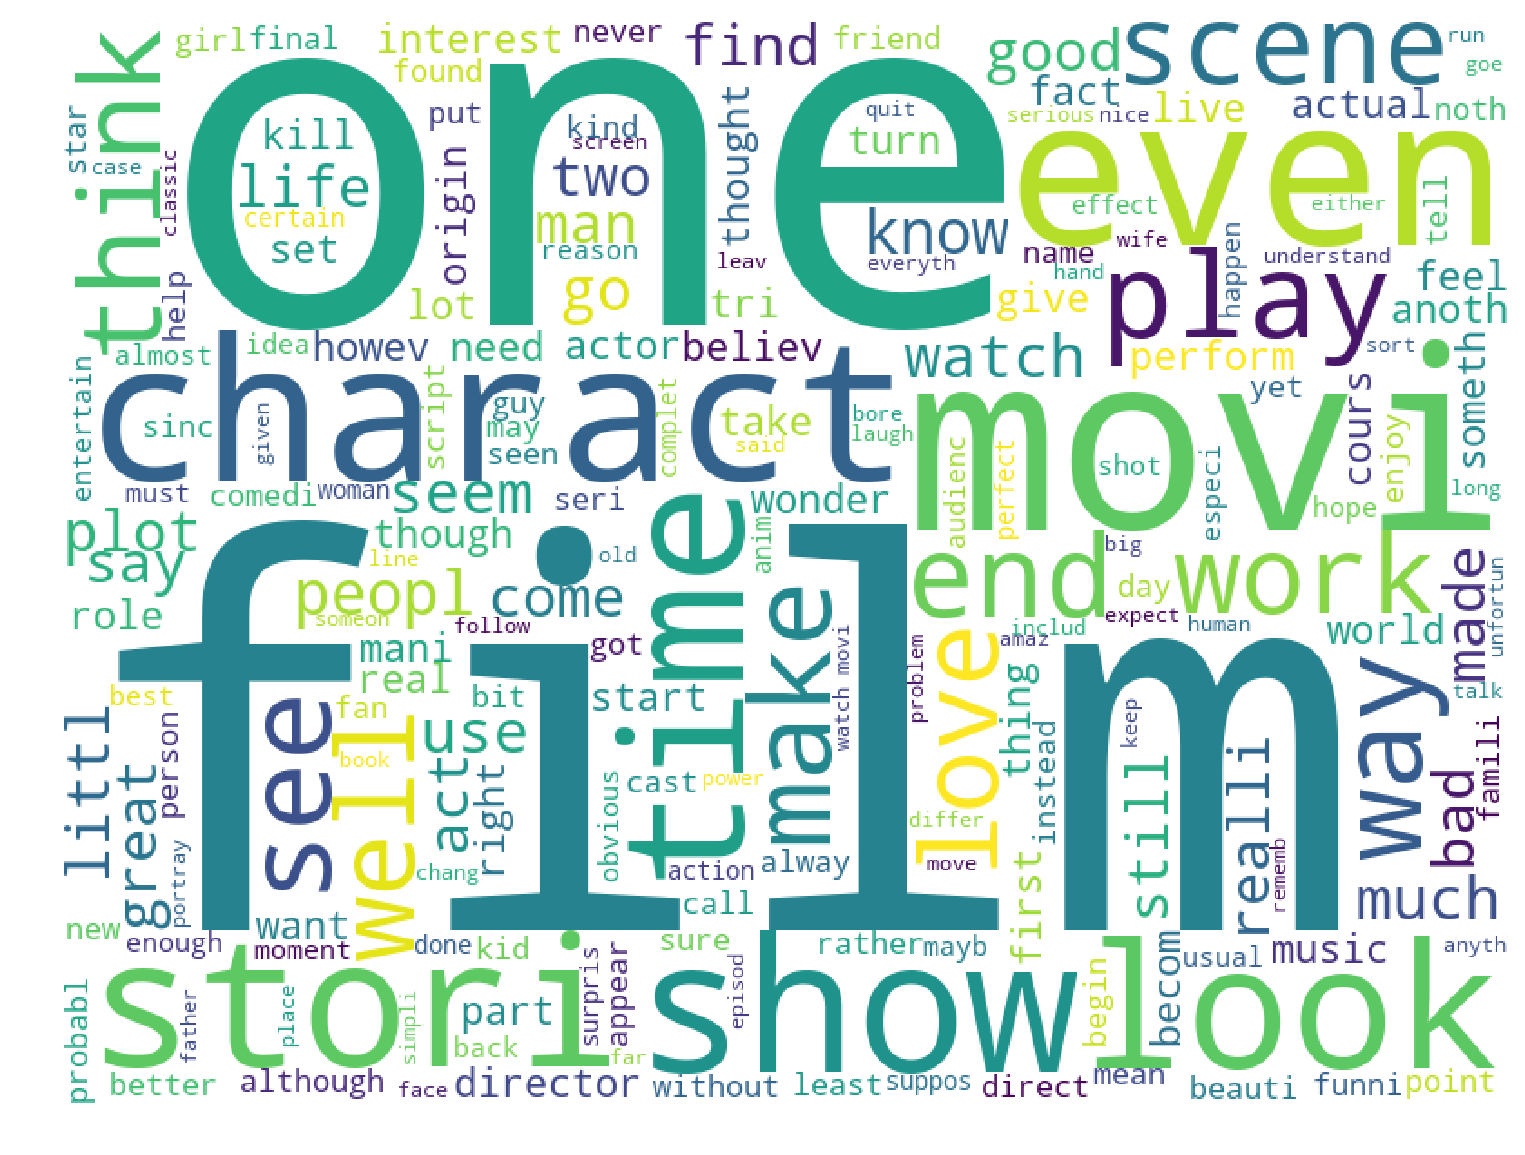

CPU times: user 25.1 s, sys: 1.15 s, total: 26.2 s
Wall time: 26.5 s


In [32]:
# train 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_train_reviews))

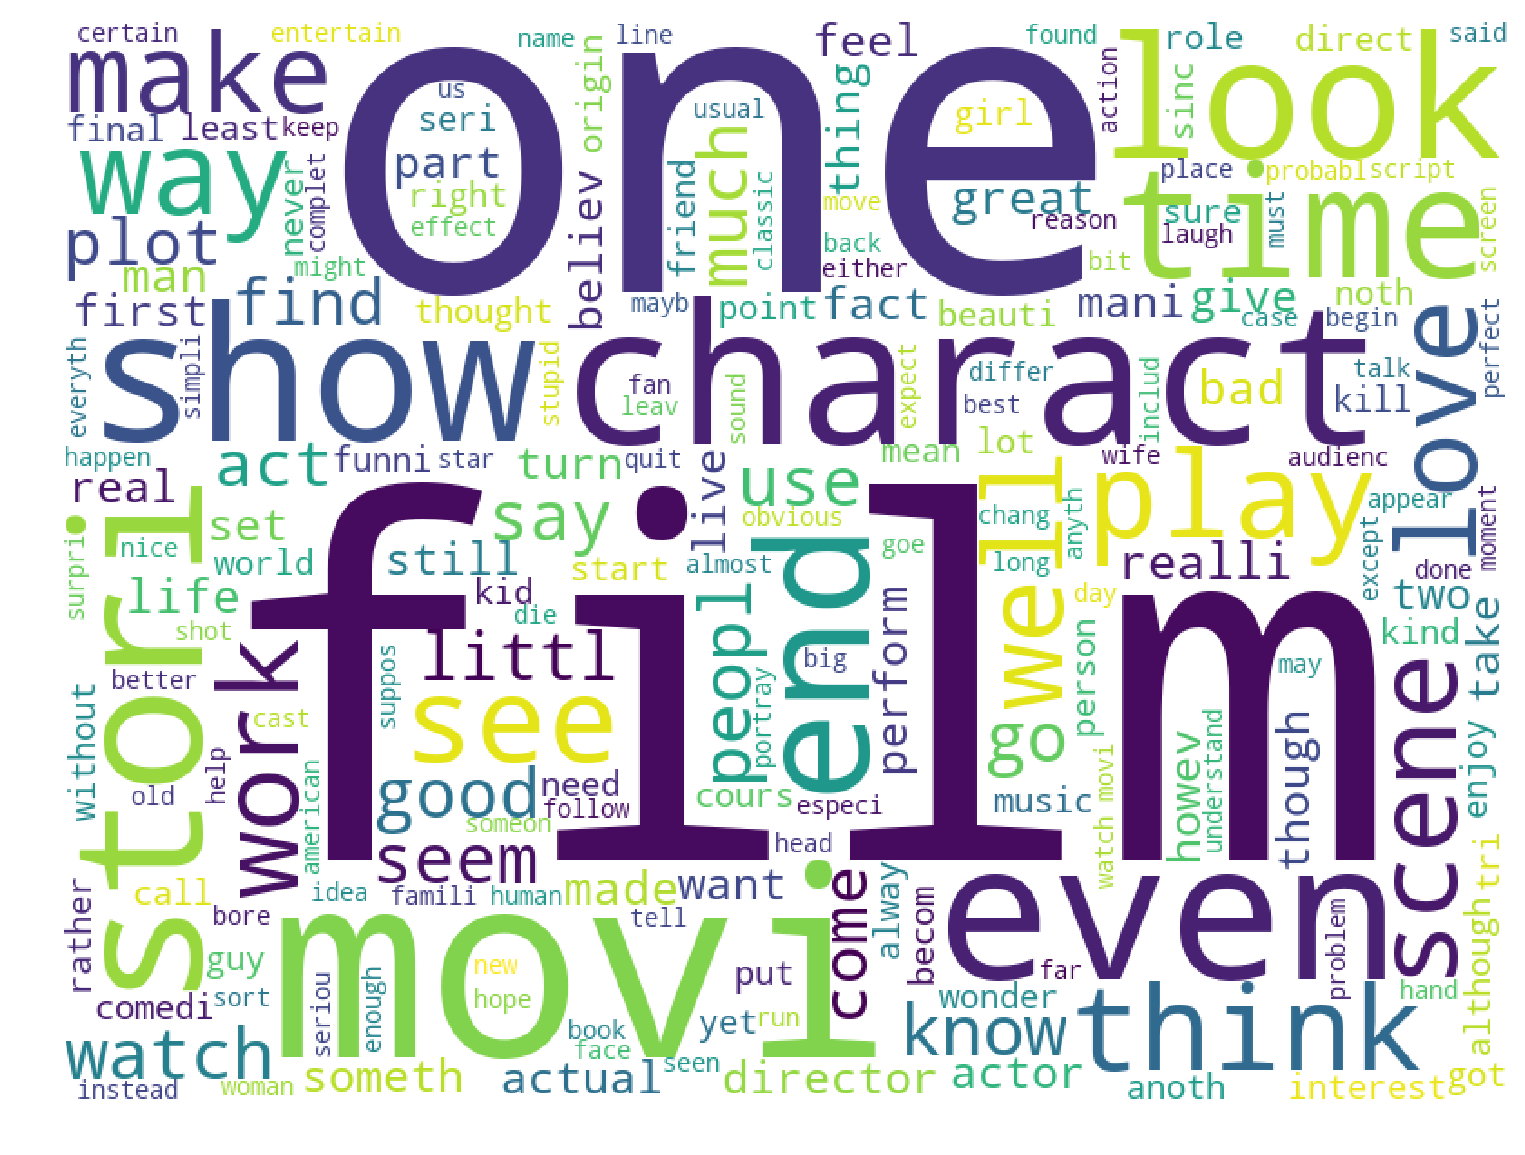

CPU times: user 25.1 s, sys: 1.12 s, total: 26.3 s
Wall time: 26.6 s


In [33]:
# test 데이터의 모든 단어에 대한 워드 클라우드를 그려본다.
%time displayWordCloud(' '.join(clean_test_reviews))

In [34]:
# 단어 수
train['num_words'] = clean_train_reviews.apply(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
train['num_uniq_words'] = clean_train_reviews.apply(lambda x: len(set(str(x).split())))

In [35]:
# 첫 번째 리뷰에 
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

리뷰별 단어 평균 값 : 119.52356
리뷰별 단어 중간 값 89.0
리뷰별 고유 단어 평균 값 : 94.05756
리뷰별 고유 단어 중간 값 74.0


/Users/macbook/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'리뷰별 고유한 단어 수 분포')

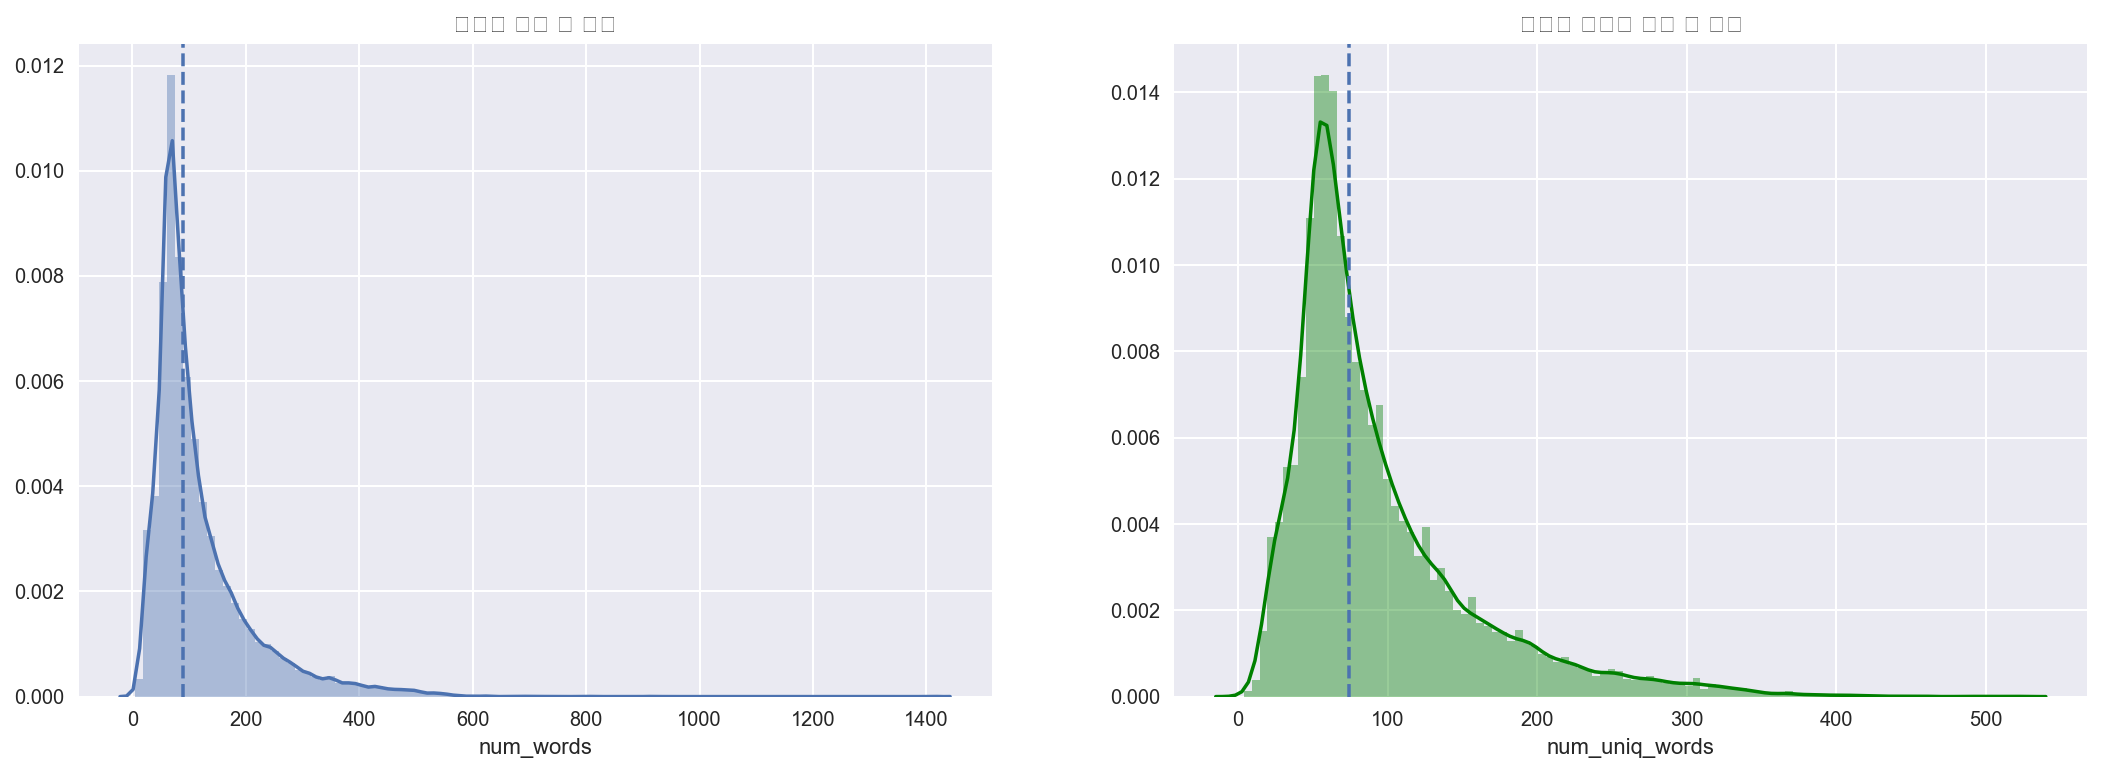

In [36]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
print('리뷰별 단어 평균 값 :', train['num_words'].mean())
print('리뷰별 단어 중간 값', train['num_words'].median())
sns.distplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('리뷰별 단어 수 분포')

print('리뷰별 고유 단어 평균 값 :', train['num_uniq_words'].mean())
print('리뷰별 고유 단어 중간 값', train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'], bins=100, color='g', ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('리뷰별 고유한 단어 수 분포')

## [Bag of words model - Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model)

다음의 두 문장이 있다고 하자.

    (1) John likes to watch movies. Mary likes movies too.
    (2) John also likes to watch football games.

위 두 문장을 토큰화 하여 가방에 담아주면 다음과 같다.

    ["John",
    "likes",
    "to",
    "watch",
    "movies",
    "Mary",
    "too",
    "also",
    "football",
    "games"]

그리고 배열의 순서대로 가방에서 각 토큰이 몇 번 등장하는지 횟수를 세어준다.

    (1) [1, 2, 1, 1, 2, 1, 1, 0, 0, 0]
    (2) [1, 1, 1, 1, 0, 0, 0, 1, 1, 1]

=> 머신러닝 알고리즘이 이해할 수 있는 형태로 바꿔주는 작업이다.

단어 가방을 n-gram을 사용해 bigram 으로 담아주면 다음과 같다.

    ["John likes",
    "likes to",
    "to watch",
    "watch movies",
    "Mary likes",
    "likes movies",
    "movies too",]
    
=> 여기에서는 CountVectorizer를 통해 위 작업을 한다.

### Scikit-Learn의 CountVectorizer를 통해 feature 생성

- 정규표현식을 사용해 토큰을 추출한다.
- 모두 소문자로 변환시키기 때문에 good, Good, gOod이 모두 같은 특성이 된다.
- 의미없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용한다.
- min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다.

### CountVectorizer의 인수

- `stop_words` : 문자열 {‘english’}, 리스트 또는 None (디폴트)
    - stop words 목록.‘english’이면 영어용 스탑 워드 사용.
- `analyzer` : 문자열 {‘word’, ‘char’, ‘char_wb’} 또는 함수
    - 단어 n-그램, 문자 n-그램, 단어 내의 문자 n-그램
- `token_pattern` : string
    - 토큰 정의용 정규 표현식
- `tokenizer` : 함수 또는 None (디폴트)
    - 토큰 생성 함수 .
- `ngram_range` : (min_n, max_n) 튜플
    - n-그램 범위
- `max_df` : 정수 또는 [0.0, 1.0] 사이의 실수. 디폴트 1
    - 단어장에 포함되기 위한 최대 빈도
- `min_df` : 정수 또는 [0.0, 1.0] 사이의 실수. 디폴트 1
    - 단어장에 포함되기 위한 최소 빈도

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# 튜토리얼과 다르게 파라미터 값을 수정
# 파라미터 값만 수정해도 캐글 스코어 차이가 많이 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3),
                             max_features = 20000)
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [38]:
# 속도 개선을 위해 파이프라인을 사용하도록 개선
# 참고 : https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [39]:
%time train_data_features = pipeline.fit_transform(clean_train_reviews)
train_data_features

CPU times: user 48 s, sys: 2.85 s, total: 50.8 s
Wall time: 1min 10s


<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2762268 stored elements in Compressed Sparse Row format>

In [40]:
train_data_features.shape

(25000, 20000)

In [41]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

20000


['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [42]:
# 벡터화 된 feature를 확인해 봄
import numpy as np
dist = np.sum(train_data_features, axis=0)
    
for tag, count in zip(vocab, dist):
    print(count, tag)

# 전체 데이터의 counts를 모두 sum한 결과
pd.DataFrame(dist, columns=vocab)

[[26 48 22 ... 59 40 23]] aag


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


In [43]:
pd.DataFrame(train_data_features[:10].toarray(), columns=vocab).head()

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### [랜덤 포레스트 - 위키백과](https://ko.wikipedia.org/wiki/%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8)

랜덤 포레스트의 가장 핵심적인 특징은 임의성(randomness)에 의해 서로 조금씩 다른 특성을 갖는 트리들로 구성된다는 점이다. 이 특징은 각 트리들의 예측(prediction)들이 비상관화(decorrelation) 되게하며, 결과적으로 일반화(generalization) 성능을 향상시킨다. 또한, 임의화(randomization)는 포레스트가 노이즈가 포함된 데이터에 대해서도 강인하게 만들어 준다.

In [44]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)

forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [45]:
%time forest = forest.fit(train_data_features, train['sentiment'])

CPU times: user 1min 34s, sys: 1.11 s, total: 1min 35s
Wall time: 36.6 s


In [46]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_data_features, \
    train['sentiment'], cv=10, scoring='roc_auc'))

CPU times: user 12min 33s, sys: 7.24 s, total: 12min 40s
Wall time: 4min 1s


In [47]:
# 위에서 정제해준 리뷰의 첫 번째 데이터를 확인
clean_test_reviews[0]

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

In [48]:
# test 데이터를 벡터화 함
%time test_data_features = pipeline.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

CPU times: user 14.9 s, sys: 701 ms, total: 15.6 s
Wall time: 26.4 s


In [49]:
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [50]:
# 벡터화 된 단어의 숫자가 문서에서 등장하는 횟수를 나타낸다
# 6번째 리뷰의 단어 100개만 확인
test_data_features[5][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
# 벡터화 하며 만든 사전에서 해당 단어가 무엇인지 찾아볼 수 있다.
# vocab = vectorizer.get_feature_names()
vocab[8], vocab[2558], vocab[2559], vocab[2560]

('abc', 'charact person', 'charact play', 'charact plot')

In [52]:
# 벡터화한 test 데이터를 넣고 예측한다.
result = forest.predict(test_data_features)
result[:10]

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0])

In [53]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",0
3,"""7186_2""",1
4,"""12128_7""",1


In [54]:
output.to_csv('data/tutorial_1_BOW_{0:.5f}.csv'.format(score), index=False, quoting=3)

In [55]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

108


0    12554
1    12446
Name: sentiment, dtype: int64

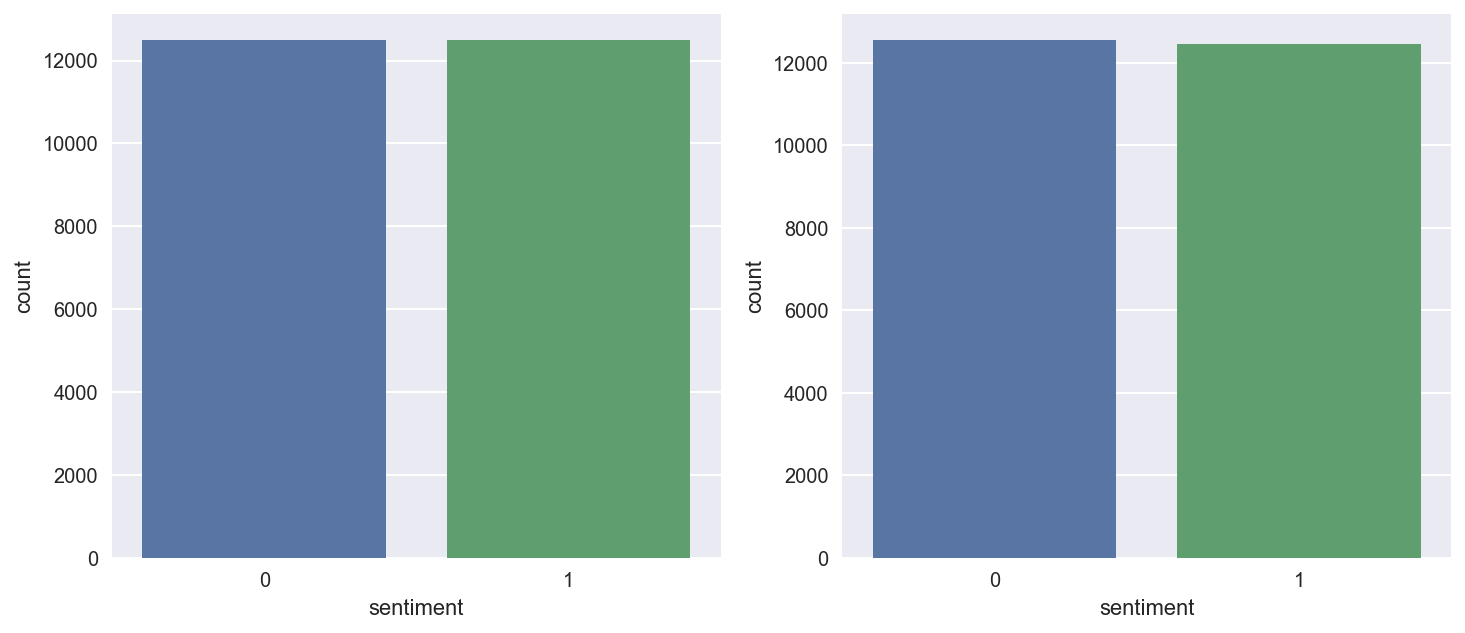

In [56]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

첫 번째 제출을 할 준비가 되었다. 리뷰를 다르게 정리하거나 'Bag of Words' 표현을 위해 다른 수의 어휘 단어를 선택하거나 포터 스테밍 등을 시도해 볼 수 있다. 다른 데이터세트로 NLP를 시도해 보려면 로튼 토마토(Rotten Tomatoes)를 해보는 것도 좋다.
- 로튼 토마토 데이터 셋을 사용하는 경진대회 : [Sentiment Analysis on Movie Reviews | Kaggle](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)

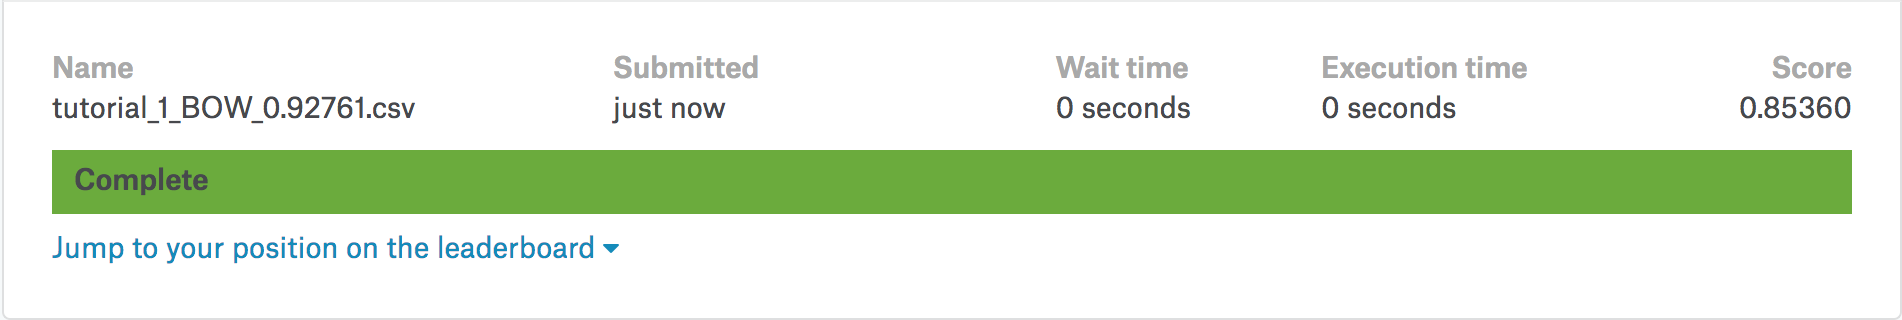

In [59]:
print(round(315/578*100, 2), "%")

54.5 %
